In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

In [2]:
import IPython.display as ipd
import warnings
import os
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn.functional as F
from torch import optim,nn
from torchvision import datasets,models,transforms

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [5]:
data_dir = '/home/mds-student/Documents/aDITYA/multimodal-speech-emotion-recognition-master/IEMOCAP_image_data'
train_dir = data_dir + '/doubling_train'
test_dir = data_dir + '/test'

In [6]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                     #transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                     #transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [7]:
trainset = datasets.ImageFolder(train_dir,transform= train_transforms)
testset = datasets.ImageFolder(test_dir,transform= test_transforms)

In [8]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64)

In [9]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 256, 768]), torch.Size([64]))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
classifier = nn.Sequential(nn.Linear(512, 200),
                           nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(200, 4))
model.fc = classifier

In [15]:
anger = 0
happiness = 0
neutral = 0
sadness = 0

for _, target in trainloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])
    
for _, target in testloader:
    labels = list(target.numpy())
    anger += len([x for x in labels if x == 0])
    happiness += len([x for x in labels if x == 1])
    neutral += len([x for x in labels if x == 2])
    sadness += len([x for x in labels if x == 3])

In [16]:
sample_weights = [1/anger, 1/happiness, 1/neutral, 1/sadness]
class_weights = torch.FloatTensor(sample_weights).cpu()
class_weights

tensor([0.0009, 0.0009, 0.0009, 0.0009])

In [17]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
model = model.to(device)

In [19]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,279,916 total parameters.
103,404 training parameters.


In [20]:
labels = list(trainloader.dataset.class_to_idx.keys())
labels

['anger', 'happiness', 'neutral', 'sadness']

In [21]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = confusion_matrix(actual, predicted, labels)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 10}, fmt='.0f'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
    plt.show()

In [22]:
label_to_class = {value: key for key, value in trainloader.dataset.class_to_idx.items()}
label_to_class

{0: 'anger', 1: 'happiness', 2: 'neutral', 3: 'sadness'}

In [23]:
def train(epoch, model):
    model.train()
    correct_train = 0
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(train_loss))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
    
    return train_loss, int(train_acc.numpy())

In [24]:
def test(model):
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    pred_model = []
    actual = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)

        # output from model
        output = model(data)

        # sum total loss
        test_loss += criterion(output, target).item()

        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        pred_model.append(pred.cpu().numpy())
        actual.append(target.data.cpu().numpy())


    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


    pred_with_label = [label_to_class[label] for label in list(np.concatenate(pred_model))]
    actual_with_label = [label_to_class[label] for label in list(np.concatenate(actual))]

    plot_confusion_matrix(actual_with_label, pred_with_label, labels)

    print('\n Classification Report \n {} \n'.format(classification_report(actual_with_label, pred_with_label)))

    return test_loss, int(test_acc.numpy())

  0%|          | 0/59 [00:00<?, ?it/s]

Train Epoch: 1 [0/3760 (0%)]	Loss: 1.352530

Train Epoch: 1 [640/3760 (17%)]	Loss: 1.361873

Train Epoch: 1 [1280/3760 (34%)]	Loss: 1.347025

Train Epoch: 1 [1920/3760 (51%)]	Loss: 1.387985

Train Epoch: 1 [2560/3760 (68%)]	Loss: 1.360662

Train Epoch: 1 [3200/3760 (85%)]	Loss: 1.357630


Train set: Average loss: 0.0214


Train Accuracy: 1185/3760 (32%)


Test set: Average loss: 0.0211, Accuracy: 218/500 (44%)



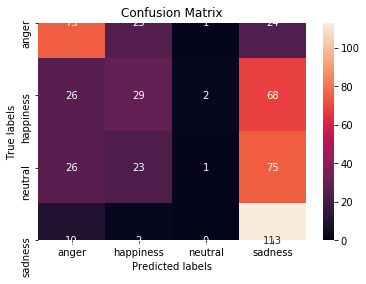

  2%|▏         | 1/59 [16:38<16:05:34, 998.87s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.60      0.57       125
   happiness       0.37      0.23      0.28       125
     neutral       0.25      0.01      0.02       125
     sadness       0.40      0.90      0.56       125

   micro avg       0.44      0.44      0.44       500
   macro avg       0.39      0.44      0.36       500
weighted avg       0.39      0.44      0.36       500
 

Train Epoch: 2 [0/3760 (0%)]	Loss: 1.333799

Train Epoch: 2 [640/3760 (17%)]	Loss: 1.340350

Train Epoch: 2 [1280/3760 (34%)]	Loss: 1.298649

Train Epoch: 2 [1920/3760 (51%)]	Loss: 1.290650

Train Epoch: 2 [2560/3760 (68%)]	Loss: 1.324958

Train Epoch: 2 [3200/3760 (85%)]	Loss: 1.276479


Train set: Average loss: 0.0207


Train Accuracy: 1457/3760 (39%)


Test set: Average loss: 0.0205, Accuracy: 244/500 (49%)



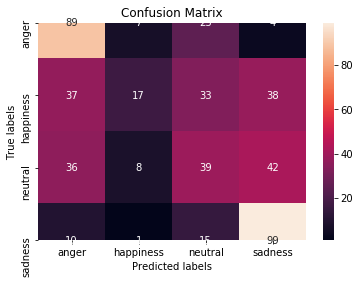

  3%|▎         | 2/59 [33:27<15:51:39, 1001.74s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.71      0.60       125
   happiness       0.52      0.14      0.22       125
     neutral       0.35      0.31      0.33       125
     sadness       0.54      0.79      0.64       125

   micro avg       0.49      0.49      0.49       500
   macro avg       0.48      0.49      0.45       500
weighted avg       0.48      0.49      0.45       500
 

Train Epoch: 3 [0/3760 (0%)]	Loss: 1.290532

Train Epoch: 3 [640/3760 (17%)]	Loss: 1.273091

Train Epoch: 3 [1280/3760 (34%)]	Loss: 1.314783

Train Epoch: 3 [1920/3760 (51%)]	Loss: 1.290719

Train Epoch: 3 [2560/3760 (68%)]	Loss: 1.303350

Train Epoch: 3 [3200/3760 (85%)]	Loss: 1.282632


Train set: Average loss: 0.0202


Train Accuracy: 1510/3760 (40%)


Test set: Average loss: 0.0200, Accuracy: 247/500 (49%)



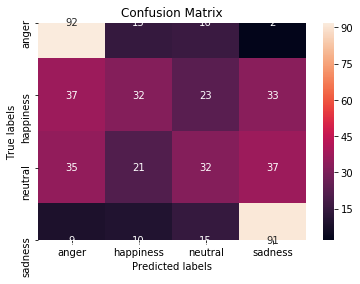

  5%|▌         | 3/59 [50:02<15:32:59, 999.63s/it] 


 Classification Report 
               precision    recall  f1-score   support

       anger       0.53      0.74      0.62       125
   happiness       0.41      0.26      0.32       125
     neutral       0.37      0.26      0.30       125
     sadness       0.56      0.73      0.63       125

   micro avg       0.49      0.49      0.49       500
   macro avg       0.47      0.49      0.47       500
weighted avg       0.47      0.49      0.47       500
 

Train Epoch: 4 [0/3760 (0%)]	Loss: 1.257315

Train Epoch: 4 [640/3760 (17%)]	Loss: 1.222656

Train Epoch: 4 [1280/3760 (34%)]	Loss: 1.227704

Train Epoch: 4 [1920/3760 (51%)]	Loss: 1.251414

Train Epoch: 4 [2560/3760 (68%)]	Loss: 1.231352

Train Epoch: 4 [3200/3760 (85%)]	Loss: 1.209844


Train set: Average loss: 0.0197


Train Accuracy: 1651/3760 (44%)


Test set: Average loss: 0.0194, Accuracy: 252/500 (50%)



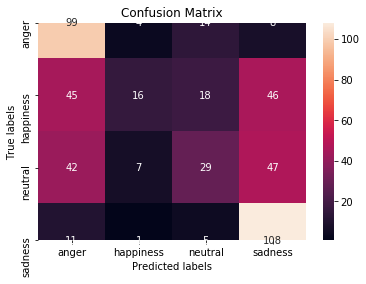

  7%|▋         | 4/59 [1:06:49<15:18:33, 1002.07s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.79      0.61       125
   happiness       0.57      0.13      0.21       125
     neutral       0.44      0.23      0.30       125
     sadness       0.52      0.86      0.65       125

   micro avg       0.50      0.50      0.50       500
   macro avg       0.51      0.50      0.44       500
weighted avg       0.51      0.50      0.44       500
 

Train Epoch: 5 [0/3760 (0%)]	Loss: 1.177923

Train Epoch: 5 [640/3760 (17%)]	Loss: 1.207963

Train Epoch: 5 [1280/3760 (34%)]	Loss: 1.253584

Train Epoch: 5 [1920/3760 (51%)]	Loss: 1.281439

Train Epoch: 5 [2560/3760 (68%)]	Loss: 1.233078

Train Epoch: 5 [3200/3760 (85%)]	Loss: 1.216441


Train set: Average loss: 0.0192


Train Accuracy: 1727/3760 (46%)


Test set: Average loss: 0.0190, Accuracy: 249/500 (50%)



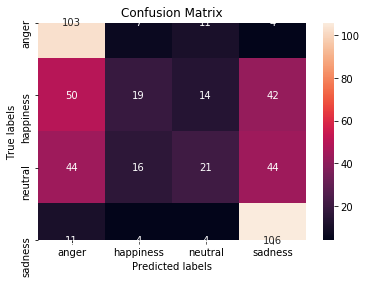

  8%|▊         | 5/59 [1:23:14<14:57:16, 996.97s/it] 


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.82      0.62       125
   happiness       0.41      0.15      0.22       125
     neutral       0.42      0.17      0.24       125
     sadness       0.54      0.85      0.66       125

   micro avg       0.50      0.50      0.50       500
   macro avg       0.47      0.50      0.44       500
weighted avg       0.47      0.50      0.44       500
 

Train Epoch: 6 [0/3760 (0%)]	Loss: 1.288559

Train Epoch: 6 [640/3760 (17%)]	Loss: 1.227055

Train Epoch: 6 [1280/3760 (34%)]	Loss: 1.158734

Train Epoch: 6 [1920/3760 (51%)]	Loss: 1.233888

Train Epoch: 6 [2560/3760 (68%)]	Loss: 1.178069

Train Epoch: 6 [3200/3760 (85%)]	Loss: 1.258861


Train set: Average loss: 0.0189


Train Accuracy: 1771/3760 (47%)


Test set: Average loss: 0.0187, Accuracy: 251/500 (50%)



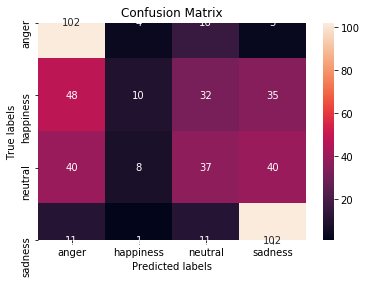

 10%|█         | 6/59 [1:39:32<14:35:34, 991.21s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.51      0.82      0.63       125
   happiness       0.43      0.08      0.14       125
     neutral       0.39      0.30      0.33       125
     sadness       0.57      0.82      0.67       125

   micro avg       0.50      0.50      0.50       500
   macro avg       0.47      0.50      0.44       500
weighted avg       0.47      0.50      0.44       500
 

Train Epoch: 7 [0/3760 (0%)]	Loss: 1.175054

Train Epoch: 7 [640/3760 (17%)]	Loss: 1.198095

Train Epoch: 7 [1280/3760 (34%)]	Loss: 1.167750

Train Epoch: 7 [1920/3760 (51%)]	Loss: 1.124848

Train Epoch: 7 [2560/3760 (68%)]	Loss: 1.256585

Train Epoch: 7 [3200/3760 (85%)]	Loss: 1.158456


Train set: Average loss: 0.0186


Train Accuracy: 1823/3760 (48%)


Test set: Average loss: 0.0185, Accuracy: 253/500 (51%)



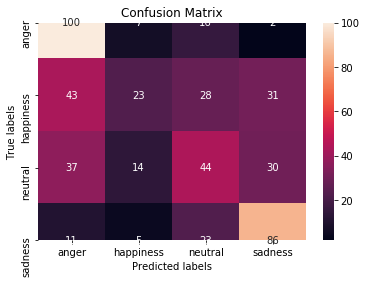

 12%|█▏        | 7/59 [1:55:51<14:15:48, 987.47s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.80      0.63       125
   happiness       0.47      0.18      0.26       125
     neutral       0.40      0.35      0.37       125
     sadness       0.58      0.69      0.63       125

   micro avg       0.51      0.51      0.51       500
   macro avg       0.49      0.51      0.47       500
weighted avg       0.49      0.51      0.47       500
 

Train Epoch: 8 [0/3760 (0%)]	Loss: 1.098245

Train Epoch: 8 [640/3760 (17%)]	Loss: 1.203059

Train Epoch: 8 [1280/3760 (34%)]	Loss: 1.139771

Train Epoch: 8 [1920/3760 (51%)]	Loss: 1.168211

Train Epoch: 8 [2560/3760 (68%)]	Loss: 1.085102

Train Epoch: 8 [3200/3760 (85%)]	Loss: 1.117313


Train set: Average loss: 0.0184


Train Accuracy: 1798/3760 (48%)


Test set: Average loss: 0.0183, Accuracy: 253/500 (51%)



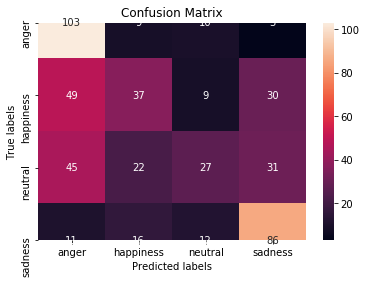

 14%|█▎        | 8/59 [2:12:12<13:57:44, 985.59s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.82      0.62       125
   happiness       0.44      0.30      0.35       125
     neutral       0.47      0.22      0.30       125
     sadness       0.57      0.69      0.63       125

   micro avg       0.51      0.51      0.51       500
   macro avg       0.49      0.51      0.47       500
weighted avg       0.49      0.51      0.47       500
 

Train Epoch: 9 [0/3760 (0%)]	Loss: 1.310835

Train Epoch: 9 [640/3760 (17%)]	Loss: 1.168898

Train Epoch: 9 [1280/3760 (34%)]	Loss: 1.132346

Train Epoch: 9 [1920/3760 (51%)]	Loss: 1.264459

Train Epoch: 9 [2560/3760 (68%)]	Loss: 1.140075

Train Epoch: 9 [3200/3760 (85%)]	Loss: 1.068536


Train set: Average loss: 0.0182


Train Accuracy: 1826/3760 (49%)


Test set: Average loss: 0.0181, Accuracy: 253/500 (51%)



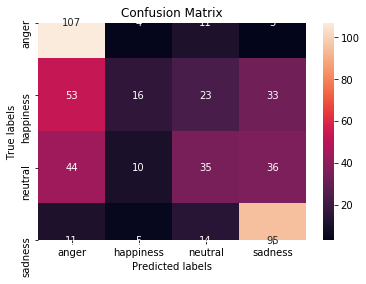

 15%|█▌        | 9/59 [2:28:35<13:40:37, 984.75s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.50      0.86      0.63       125
   happiness       0.46      0.13      0.20       125
     neutral       0.42      0.28      0.34       125
     sadness       0.57      0.76      0.65       125

   micro avg       0.51      0.51      0.51       500
   macro avg       0.49      0.51      0.45       500
weighted avg       0.49      0.51      0.45       500
 

Train Epoch: 10 [0/3760 (0%)]	Loss: 1.189878

Train Epoch: 10 [640/3760 (17%)]	Loss: 1.139337

Train Epoch: 10 [1280/3760 (34%)]	Loss: 1.180304

Train Epoch: 10 [1920/3760 (51%)]	Loss: 1.149750

Train Epoch: 10 [2560/3760 (68%)]	Loss: 1.183545

Train Epoch: 10 [3200/3760 (85%)]	Loss: 1.149078


Train set: Average loss: 0.0180


Train Accuracy: 1874/3760 (50%)


Test set: Average loss: 0.0178, Accuracy: 260/500 (52%)



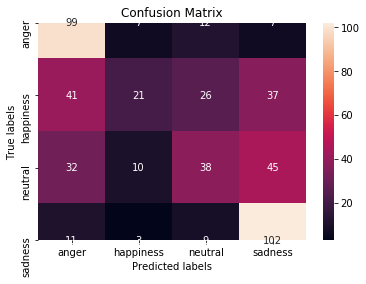

 17%|█▋        | 10/59 [2:46:24<13:44:49, 1009.99s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.54      0.79      0.64       125
   happiness       0.51      0.17      0.25       125
     neutral       0.45      0.30      0.36       125
     sadness       0.53      0.82      0.65       125

   micro avg       0.52      0.52      0.52       500
   macro avg       0.51      0.52      0.48       500
weighted avg       0.51      0.52      0.48       500
 

Train Epoch: 11 [0/3760 (0%)]	Loss: 0.997604

Train Epoch: 11 [640/3760 (17%)]	Loss: 1.082954

Train Epoch: 11 [1280/3760 (34%)]	Loss: 1.149837

Train Epoch: 11 [1920/3760 (51%)]	Loss: 1.269489

Train Epoch: 11 [2560/3760 (68%)]	Loss: 1.089129

Train Epoch: 11 [3200/3760 (85%)]	Loss: 1.201448


Train set: Average loss: 0.0179


Train Accuracy: 1901/3760 (51%)


Test set: Average loss: 0.0177, Accuracy: 270/500 (54%)



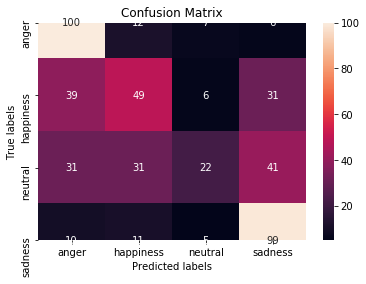

 19%|█▊        | 11/59 [3:03:10<13:27:09, 1008.96s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.56      0.80      0.66       125
   happiness       0.48      0.39      0.43       125
     neutral       0.55      0.18      0.27       125
     sadness       0.56      0.79      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.54      0.54      0.50       500
weighted avg       0.54      0.54      0.50       500
 

Train Epoch: 12 [0/3760 (0%)]	Loss: 1.133841

Train Epoch: 12 [640/3760 (17%)]	Loss: 1.136724

Train Epoch: 12 [1280/3760 (34%)]	Loss: 1.119901

Train Epoch: 12 [1920/3760 (51%)]	Loss: 1.074606

Train Epoch: 12 [2560/3760 (68%)]	Loss: 1.141589

Train Epoch: 12 [3200/3760 (85%)]	Loss: 1.202722


Train set: Average loss: 0.0177


Train Accuracy: 1894/3760 (50%)


Test set: Average loss: 0.0176, Accuracy: 267/500 (53%)



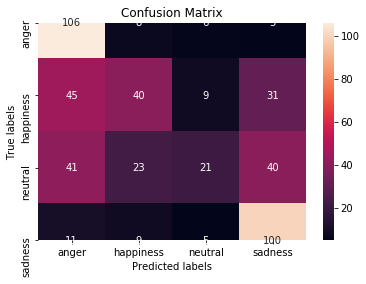

 20%|██        | 12/59 [3:19:54<13:09:13, 1007.53s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.52      0.85      0.65       125
   happiness       0.50      0.32      0.39       125
     neutral       0.51      0.17      0.25       125
     sadness       0.57      0.80      0.66       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.53      0.53      0.49       500
weighted avg       0.53      0.53      0.49       500
 

Train Epoch: 13 [0/3760 (0%)]	Loss: 1.280704

Train Epoch: 13 [640/3760 (17%)]	Loss: 1.137086

Train Epoch: 13 [1280/3760 (34%)]	Loss: 1.104143

Train Epoch: 13 [1920/3760 (51%)]	Loss: 1.094938

Train Epoch: 13 [2560/3760 (68%)]	Loss: 1.202654

Train Epoch: 13 [3200/3760 (85%)]	Loss: 1.029745


Train set: Average loss: 0.0176


Train Accuracy: 1870/3760 (50%)


Test set: Average loss: 0.0175, Accuracy: 259/500 (52%)



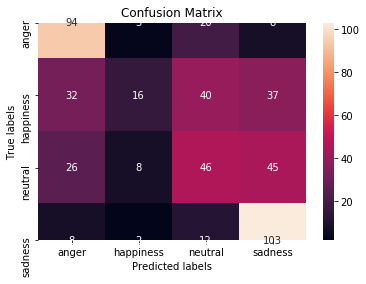

 22%|██▏       | 13/59 [3:36:12<12:45:28, 998.44s/it] 


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.75      0.66       125
   happiness       0.55      0.13      0.21       125
     neutral       0.39      0.37      0.38       125
     sadness       0.53      0.82      0.65       125

   micro avg       0.52      0.52      0.52       500
   macro avg       0.52      0.52      0.47       500
weighted avg       0.52      0.52      0.47       500
 

Train Epoch: 14 [0/3760 (0%)]	Loss: 1.063746

Train Epoch: 14 [640/3760 (17%)]	Loss: 1.181486

Train Epoch: 14 [1280/3760 (34%)]	Loss: 1.068936

Train Epoch: 14 [1920/3760 (51%)]	Loss: 1.050012

Train Epoch: 14 [2560/3760 (68%)]	Loss: 1.111695

Train Epoch: 14 [3200/3760 (85%)]	Loss: 1.031510


Train set: Average loss: 0.0175


Train Accuracy: 1936/3760 (51%)


Test set: Average loss: 0.0174, Accuracy: 268/500 (54%)



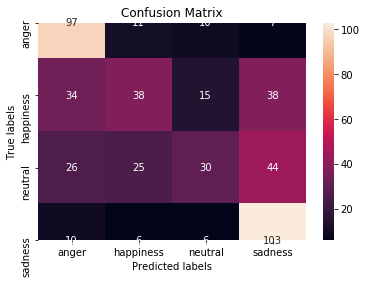

 24%|██▎       | 14/59 [3:52:33<12:25:04, 993.44s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.78      0.66       125
   happiness       0.47      0.30      0.37       125
     neutral       0.49      0.24      0.32       125
     sadness       0.54      0.82      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.50       500
weighted avg       0.52      0.54      0.50       500
 

Train Epoch: 15 [0/3760 (0%)]	Loss: 1.170327

Train Epoch: 15 [640/3760 (17%)]	Loss: 1.062255

Train Epoch: 15 [1280/3760 (34%)]	Loss: 1.040969

Train Epoch: 15 [1920/3760 (51%)]	Loss: 0.993945

Train Epoch: 15 [2560/3760 (68%)]	Loss: 1.167578

Train Epoch: 15 [3200/3760 (85%)]	Loss: 1.097702


Train set: Average loss: 0.0173


Train Accuracy: 1923/3760 (51%)


Test set: Average loss: 0.0173, Accuracy: 265/500 (53%)



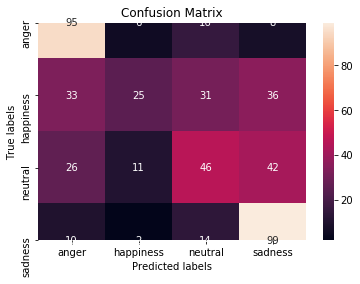

 25%|██▌       | 15/59 [4:08:55<12:05:56, 989.92s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.76      0.66       125
   happiness       0.57      0.20      0.30       125
     neutral       0.43      0.37      0.40       125
     sadness       0.54      0.79      0.64       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.53      0.53      0.50       500
weighted avg       0.53      0.53      0.50       500
 

Train Epoch: 16 [0/3760 (0%)]	Loss: 1.197121

Train Epoch: 16 [640/3760 (17%)]	Loss: 1.025441

Train Epoch: 16 [1280/3760 (34%)]	Loss: 1.062089

Train Epoch: 16 [1920/3760 (51%)]	Loss: 0.952981

Train Epoch: 16 [2560/3760 (68%)]	Loss: 0.988095

Train Epoch: 16 [3200/3760 (85%)]	Loss: 1.076805


Train set: Average loss: 0.0173


Train Accuracy: 1960/3760 (52%)


Test set: Average loss: 0.0172, Accuracy: 271/500 (54%)



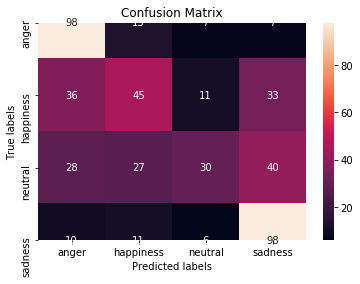

 27%|██▋       | 16/59 [4:24:56<11:43:14, 981.27s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.78      0.66       125
   happiness       0.47      0.36      0.41       125
     neutral       0.56      0.24      0.34       125
     sadness       0.55      0.78      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.54      0.54      0.51       500
weighted avg       0.54      0.54      0.51       500
 

Train Epoch: 17 [0/3760 (0%)]	Loss: 1.095133

Train Epoch: 17 [640/3760 (17%)]	Loss: 1.144426

Train Epoch: 17 [1280/3760 (34%)]	Loss: 1.151526

Train Epoch: 17 [1920/3760 (51%)]	Loss: 1.160768

Train Epoch: 17 [2560/3760 (68%)]	Loss: 1.056206

Train Epoch: 17 [3200/3760 (85%)]	Loss: 1.042985


Train set: Average loss: 0.0171


Train Accuracy: 1967/3760 (52%)


Test set: Average loss: 0.0172, Accuracy: 263/500 (53%)



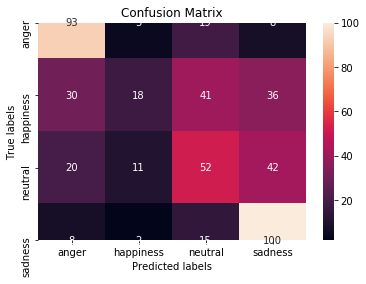

 29%|██▉       | 17/59 [4:40:54<11:21:56, 974.21s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.62      0.74      0.67       125
   happiness       0.50      0.14      0.22       125
     neutral       0.41      0.42      0.41       125
     sadness       0.54      0.80      0.64       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.52      0.53      0.49       500
weighted avg       0.52      0.53      0.49       500
 

Train Epoch: 18 [0/3760 (0%)]	Loss: 1.063337

Train Epoch: 18 [640/3760 (17%)]	Loss: 1.192175

Train Epoch: 18 [1280/3760 (34%)]	Loss: 1.015750

Train Epoch: 18 [1920/3760 (51%)]	Loss: 1.239743

Train Epoch: 18 [2560/3760 (68%)]	Loss: 1.204257

Train Epoch: 18 [3200/3760 (85%)]	Loss: 1.216384


Train set: Average loss: 0.0171


Train Accuracy: 1988/3760 (53%)


Test set: Average loss: 0.0171, Accuracy: 271/500 (54%)



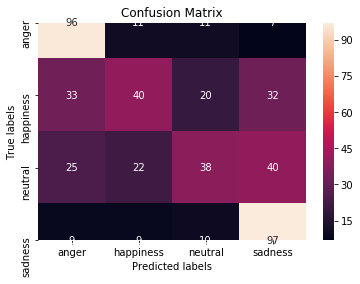

 31%|███       | 18/59 [4:56:54<11:02:48, 969.96s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.77      0.67       125
   happiness       0.49      0.32      0.39       125
     neutral       0.48      0.30      0.37       125
     sadness       0.55      0.78      0.64       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.52       500
weighted avg       0.53      0.54      0.52       500
 

Train Epoch: 19 [0/3760 (0%)]	Loss: 1.042462

Train Epoch: 19 [640/3760 (17%)]	Loss: 1.056232

Train Epoch: 19 [1280/3760 (34%)]	Loss: 0.999991

Train Epoch: 19 [1920/3760 (51%)]	Loss: 1.113173

Train Epoch: 19 [2560/3760 (68%)]	Loss: 1.125791

Train Epoch: 19 [3200/3760 (85%)]	Loss: 0.949724


Train set: Average loss: 0.0170


Train Accuracy: 2003/3760 (53%)


Test set: Average loss: 0.0170, Accuracy: 263/500 (53%)



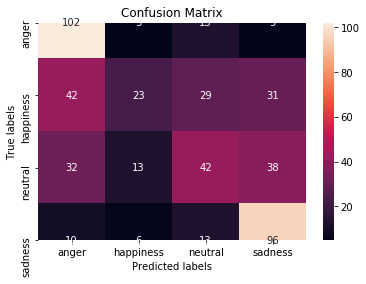

 32%|███▏      | 19/59 [5:12:54<10:44:41, 967.05s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.55      0.82      0.66       125
   happiness       0.49      0.18      0.27       125
     neutral       0.43      0.34      0.38       125
     sadness       0.56      0.77      0.65       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.51      0.53      0.49       500
weighted avg       0.51      0.53      0.49       500
 

Train Epoch: 20 [0/3760 (0%)]	Loss: 1.024219

Train Epoch: 20 [640/3760 (17%)]	Loss: 1.044778

Train Epoch: 20 [1280/3760 (34%)]	Loss: 1.066241

Train Epoch: 20 [1920/3760 (51%)]	Loss: 1.146894

Train Epoch: 20 [2560/3760 (68%)]	Loss: 1.198939

Train Epoch: 20 [3200/3760 (85%)]	Loss: 1.118981


Train set: Average loss: 0.0170


Train Accuracy: 1963/3760 (52%)


Test set: Average loss: 0.0170, Accuracy: 263/500 (53%)



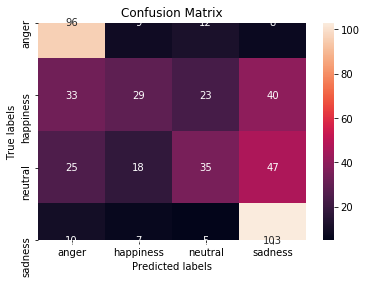

 34%|███▍      | 20/59 [5:28:56<10:27:32, 965.44s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.77      0.66       125
   happiness       0.46      0.23      0.31       125
     neutral       0.47      0.28      0.35       125
     sadness       0.52      0.82      0.64       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.51      0.53      0.49       500
weighted avg       0.51      0.53      0.49       500
 

Train Epoch: 21 [0/3760 (0%)]	Loss: 1.089218

Train Epoch: 21 [640/3760 (17%)]	Loss: 1.169628

Train Epoch: 21 [1280/3760 (34%)]	Loss: 1.134894

Train Epoch: 21 [1920/3760 (51%)]	Loss: 1.037819

Train Epoch: 21 [2560/3760 (68%)]	Loss: 0.961786

Train Epoch: 21 [3200/3760 (85%)]	Loss: 0.988604


Train set: Average loss: 0.0168


Train Accuracy: 1997/3760 (53%)


Test set: Average loss: 0.0170, Accuracy: 263/500 (53%)



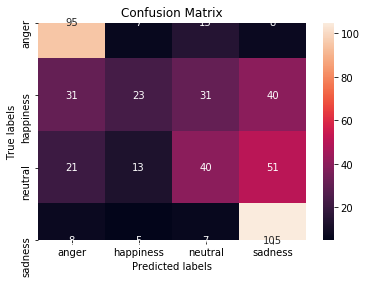

 36%|███▌      | 21/59 [5:44:57<10:10:34, 964.06s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.76      0.68       125
   happiness       0.48      0.18      0.27       125
     neutral       0.43      0.32      0.37       125
     sadness       0.51      0.84      0.64       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.51      0.53      0.49       500
weighted avg       0.51      0.53      0.49       500
 

Train Epoch: 22 [0/3760 (0%)]	Loss: 1.173365

Train Epoch: 22 [640/3760 (17%)]	Loss: 1.053000

Train Epoch: 22 [1280/3760 (34%)]	Loss: 1.013074

Train Epoch: 22 [1920/3760 (51%)]	Loss: 1.096734

Train Epoch: 22 [2560/3760 (68%)]	Loss: 0.920411

Train Epoch: 22 [3200/3760 (85%)]	Loss: 1.048883


Train set: Average loss: 0.0168


Train Accuracy: 2027/3760 (54%)


Test set: Average loss: 0.0169, Accuracy: 278/500 (56%)



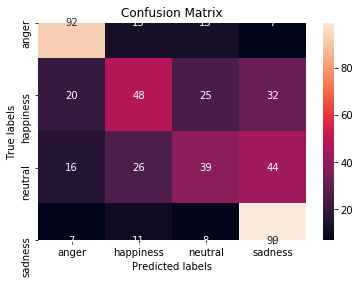

 37%|███▋      | 22/59 [6:00:57<9:53:52, 963.04s/it] 


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.74      0.71       125
   happiness       0.49      0.38      0.43       125
     neutral       0.46      0.31      0.37       125
     sadness       0.54      0.79      0.64       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.54      0.56      0.54       500
weighted avg       0.54      0.56      0.54       500
 

Train Epoch: 23 [0/3760 (0%)]	Loss: 1.231869

Train Epoch: 23 [640/3760 (17%)]	Loss: 1.089389

Train Epoch: 23 [1280/3760 (34%)]	Loss: 0.998114

Train Epoch: 23 [1920/3760 (51%)]	Loss: 1.019824

Train Epoch: 23 [2560/3760 (68%)]	Loss: 1.128812

Train Epoch: 23 [3200/3760 (85%)]	Loss: 1.039333


Train set: Average loss: 0.0168


Train Accuracy: 2024/3760 (54%)


Test set: Average loss: 0.0168, Accuracy: 269/500 (54%)



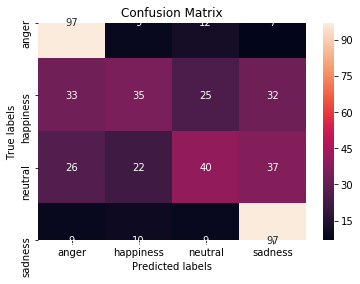

 39%|███▉      | 23/59 [6:16:53<9:36:30, 960.85s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.78      0.67       125
   happiness       0.46      0.28      0.35       125
     neutral       0.47      0.32      0.38       125
     sadness       0.56      0.78      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 24 [0/3760 (0%)]	Loss: 0.939085

Train Epoch: 24 [640/3760 (17%)]	Loss: 1.011468

Train Epoch: 24 [1280/3760 (34%)]	Loss: 1.038038

Train Epoch: 24 [1920/3760 (51%)]	Loss: 1.043411

Train Epoch: 24 [2560/3760 (68%)]	Loss: 1.027362

Train Epoch: 24 [3200/3760 (85%)]	Loss: 1.069750


Train set: Average loss: 0.0167


Train Accuracy: 2001/3760 (53%)


Test set: Average loss: 0.0168, Accuracy: 271/500 (54%)



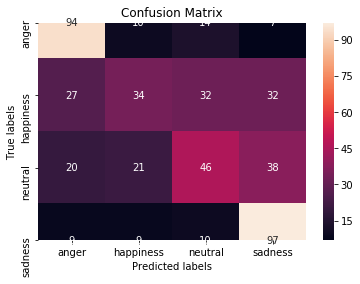

 41%|████      | 24/59 [6:32:51<9:20:02, 960.07s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.75      0.68       125
   happiness       0.46      0.27      0.34       125
     neutral       0.45      0.37      0.41       125
     sadness       0.56      0.78      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.52       500
weighted avg       0.52      0.54      0.52       500
 

Train Epoch: 25 [0/3760 (0%)]	Loss: 0.965397

Train Epoch: 25 [640/3760 (17%)]	Loss: 0.920607

Train Epoch: 25 [1280/3760 (34%)]	Loss: 0.993249

Train Epoch: 25 [1920/3760 (51%)]	Loss: 1.153713

Train Epoch: 25 [2560/3760 (68%)]	Loss: 1.025991

Train Epoch: 25 [3200/3760 (85%)]	Loss: 1.087856


Train set: Average loss: 0.0166


Train Accuracy: 2069/3760 (55%)


Test set: Average loss: 0.0168, Accuracy: 266/500 (53%)



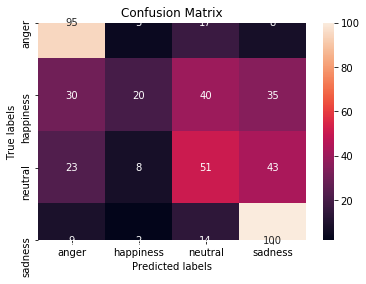

 42%|████▏     | 25/59 [6:48:50<9:03:50, 959.72s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.76      0.67       125
   happiness       0.57      0.16      0.25       125
     neutral       0.42      0.41      0.41       125
     sadness       0.54      0.80      0.64       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.53      0.53      0.49       500
weighted avg       0.53      0.53      0.49       500
 

Train Epoch: 26 [0/3760 (0%)]	Loss: 1.064221

Train Epoch: 26 [640/3760 (17%)]	Loss: 1.083654

Train Epoch: 26 [1280/3760 (34%)]	Loss: 0.985762

Train Epoch: 26 [1920/3760 (51%)]	Loss: 1.075264

Train Epoch: 26 [2560/3760 (68%)]	Loss: 1.191564

Train Epoch: 26 [3200/3760 (85%)]	Loss: 1.069970


Train set: Average loss: 0.0165


Train Accuracy: 2043/3760 (54%)


Test set: Average loss: 0.0167, Accuracy: 260/500 (52%)



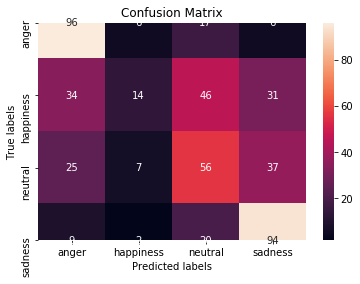


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.77      0.66       125
   happiness       0.48      0.11      0.18       125
     neutral       0.40      0.45      0.42       125
     sadness       0.56      0.75      0.64       125

   micro avg       0.52      0.52      0.52       500
   macro avg       0.51      0.52      0.48       500
weighted avg       0.51      0.52      0.48       500
 



 44%|████▍     | 26/59 [7:04:55<8:48:36, 961.09s/it]

Train Epoch: 27 [0/3760 (0%)]	Loss: 1.022803

Train Epoch: 27 [640/3760 (17%)]	Loss: 0.972984

Train Epoch: 27 [1280/3760 (34%)]	Loss: 1.039478

Train Epoch: 27 [1920/3760 (51%)]	Loss: 1.108648

Train Epoch: 27 [2560/3760 (68%)]	Loss: 1.017805

Train Epoch: 27 [3200/3760 (85%)]	Loss: 1.062183


Train set: Average loss: 0.0166


Train Accuracy: 2071/3760 (55%)


Test set: Average loss: 0.0167, Accuracy: 268/500 (54%)



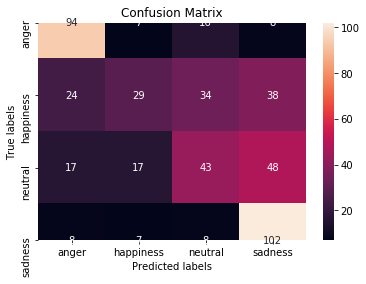

 46%|████▌     | 27/59 [7:20:56<8:32:37, 961.17s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.75      0.70       125
   happiness       0.48      0.23      0.31       125
     neutral       0.43      0.34      0.38       125
     sadness       0.52      0.82      0.64       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 28 [0/3760 (0%)]	Loss: 1.007808

Train Epoch: 28 [640/3760 (17%)]	Loss: 0.967066

Train Epoch: 28 [1280/3760 (34%)]	Loss: 0.920268

Train Epoch: 28 [1920/3760 (51%)]	Loss: 0.973967

Train Epoch: 28 [2560/3760 (68%)]	Loss: 0.955865

Train Epoch: 28 [3200/3760 (85%)]	Loss: 0.981227


Train set: Average loss: 0.0165


Train Accuracy: 2084/3760 (55%)


Test set: Average loss: 0.0167, Accuracy: 266/500 (53%)



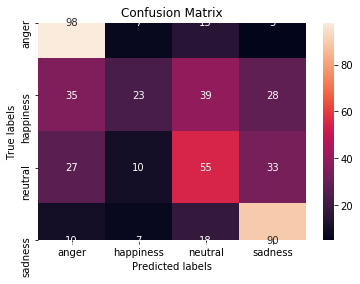

 47%|████▋     | 28/59 [7:36:56<8:16:26, 960.87s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.58      0.78      0.66       125
   happiness       0.49      0.18      0.27       125
     neutral       0.43      0.44      0.44       125
     sadness       0.58      0.72      0.64       125

   micro avg       0.53      0.53      0.53       500
   macro avg       0.52      0.53      0.50       500
weighted avg       0.52      0.53      0.50       500
 

Train Epoch: 29 [0/3760 (0%)]	Loss: 1.123103

Train Epoch: 29 [640/3760 (17%)]	Loss: 1.039629

Train Epoch: 29 [1280/3760 (34%)]	Loss: 1.027500

Train Epoch: 29 [1920/3760 (51%)]	Loss: 1.078992

Train Epoch: 29 [2560/3760 (68%)]	Loss: 1.027289

Train Epoch: 29 [3200/3760 (85%)]	Loss: 1.115281


Train set: Average loss: 0.0164


Train Accuracy: 2081/3760 (55%)


Test set: Average loss: 0.0166, Accuracy: 279/500 (56%)



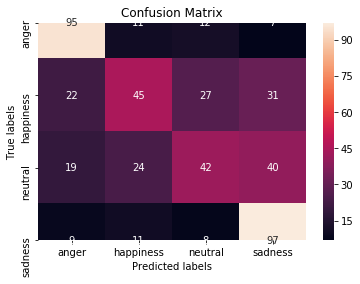

 49%|████▉     | 29/59 [7:52:57<8:00:28, 960.94s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.76      0.70       125
   happiness       0.49      0.36      0.42       125
     neutral       0.47      0.34      0.39       125
     sadness       0.55      0.78      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.54      0.56      0.54       500
weighted avg       0.54      0.56      0.54       500
 

Train Epoch: 30 [0/3760 (0%)]	Loss: 0.941321

Train Epoch: 30 [640/3760 (17%)]	Loss: 1.112035

Train Epoch: 30 [1280/3760 (34%)]	Loss: 1.114088

Train Epoch: 30 [1920/3760 (51%)]	Loss: 0.978968

Train Epoch: 30 [2560/3760 (68%)]	Loss: 0.969150

Train Epoch: 30 [3200/3760 (85%)]	Loss: 1.117655


Train set: Average loss: 0.0163


Train Accuracy: 2094/3760 (56%)


Test set: Average loss: 0.0166, Accuracy: 269/500 (54%)



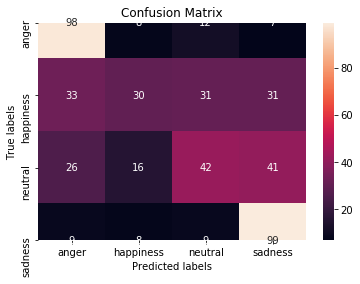

 51%|█████     | 30/59 [8:08:59<7:44:37, 961.29s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.59      0.78      0.67       125
   happiness       0.48      0.24      0.32       125
     neutral       0.45      0.34      0.38       125
     sadness       0.56      0.79      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.52      0.54      0.51       500
weighted avg       0.52      0.54      0.51       500
 

Train Epoch: 31 [0/3760 (0%)]	Loss: 1.120716

Train Epoch: 31 [640/3760 (17%)]	Loss: 1.098009

Train Epoch: 31 [1280/3760 (34%)]	Loss: 1.117264

Train Epoch: 31 [1920/3760 (51%)]	Loss: 0.998907

Train Epoch: 31 [2560/3760 (68%)]	Loss: 1.002886

Train Epoch: 31 [3200/3760 (85%)]	Loss: 0.983988


Train set: Average loss: 0.0162


Train Accuracy: 2085/3760 (55%)


Test set: Average loss: 0.0165, Accuracy: 270/500 (54%)



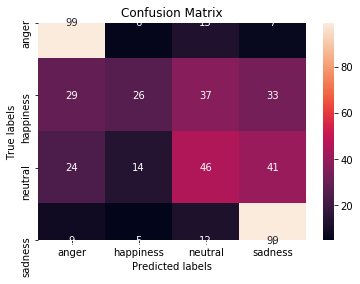

 53%|█████▎    | 31/59 [8:25:03<7:28:57, 962.07s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.79      0.69       125
   happiness       0.51      0.21      0.30       125
     neutral       0.43      0.37      0.39       125
     sadness       0.55      0.79      0.65       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.51       500
weighted avg       0.53      0.54      0.51       500
 

Train Epoch: 32 [0/3760 (0%)]	Loss: 1.142460

Train Epoch: 32 [640/3760 (17%)]	Loss: 1.086878

Train Epoch: 32 [1280/3760 (34%)]	Loss: 1.089202

Train Epoch: 32 [1920/3760 (51%)]	Loss: 1.005442

Train Epoch: 32 [2560/3760 (68%)]	Loss: 1.046903

Train Epoch: 32 [3200/3760 (85%)]	Loss: 1.045682


Train set: Average loss: 0.0162


Train Accuracy: 2054/3760 (55%)


Test set: Average loss: 0.0165, Accuracy: 275/500 (55%)



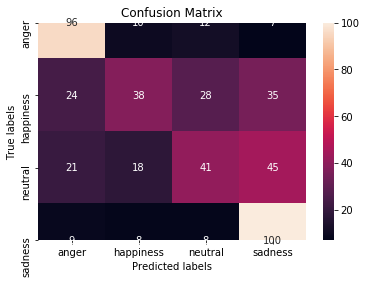

 54%|█████▍    | 32/59 [8:41:22<7:15:09, 967.02s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.77      0.70       125
   happiness       0.51      0.30      0.38       125
     neutral       0.46      0.33      0.38       125
     sadness       0.53      0.80      0.64       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.53       500
weighted avg       0.54      0.55      0.53       500
 

Train Epoch: 33 [0/3760 (0%)]	Loss: 0.935654

Train Epoch: 33 [640/3760 (17%)]	Loss: 1.082632

Train Epoch: 33 [1280/3760 (34%)]	Loss: 0.930025

Train Epoch: 33 [1920/3760 (51%)]	Loss: 1.024110

Train Epoch: 33 [2560/3760 (68%)]	Loss: 0.913728

Train Epoch: 33 [3200/3760 (85%)]	Loss: 1.070125


Train set: Average loss: 0.0161


Train Accuracy: 2115/3760 (56%)


Test set: Average loss: 0.0165, Accuracy: 281/500 (56%)



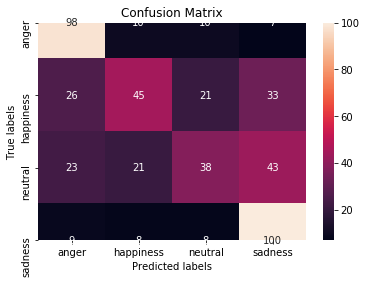

 56%|█████▌    | 33/59 [8:57:37<7:00:06, 969.47s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.78      0.70       125
   happiness       0.54      0.36      0.43       125
     neutral       0.49      0.30      0.38       125
     sadness       0.55      0.80      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 34 [0/3760 (0%)]	Loss: 1.020751

Train Epoch: 34 [640/3760 (17%)]	Loss: 0.991151

Train Epoch: 34 [1280/3760 (34%)]	Loss: 1.130284

Train Epoch: 34 [1920/3760 (51%)]	Loss: 1.109358

Train Epoch: 34 [2560/3760 (68%)]	Loss: 1.074330

Train Epoch: 34 [3200/3760 (85%)]	Loss: 0.985819


Train set: Average loss: 0.0162


Train Accuracy: 2104/3760 (56%)


Test set: Average loss: 0.0165, Accuracy: 273/500 (55%)



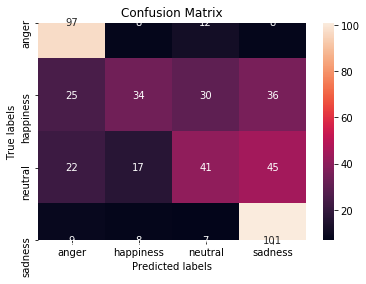

 58%|█████▊    | 34/59 [9:13:38<6:42:50, 966.81s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.78      0.70       125
   happiness       0.51      0.27      0.35       125
     neutral       0.46      0.33      0.38       125
     sadness       0.53      0.81      0.64       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.53      0.55      0.52       500
weighted avg       0.53      0.55      0.52       500
 

Train Epoch: 35 [0/3760 (0%)]	Loss: 1.045101

Train Epoch: 35 [640/3760 (17%)]	Loss: 1.012983

Train Epoch: 35 [1280/3760 (34%)]	Loss: 1.044521

Train Epoch: 35 [1920/3760 (51%)]	Loss: 1.056673

Train Epoch: 35 [2560/3760 (68%)]	Loss: 1.053833

Train Epoch: 35 [3200/3760 (85%)]	Loss: 0.978533


Train set: Average loss: 0.0161


Train Accuracy: 2133/3760 (57%)


Test set: Average loss: 0.0164, Accuracy: 274/500 (55%)



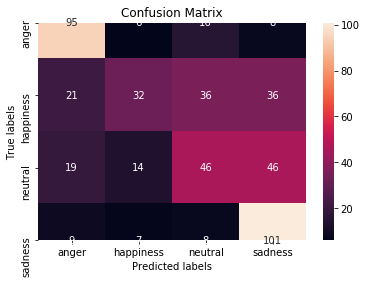

 59%|█████▉    | 35/59 [9:29:56<6:28:09, 970.39s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.76      0.71       125
   happiness       0.54      0.26      0.35       125
     neutral       0.43      0.37      0.40       125
     sadness       0.53      0.81      0.64       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.52       500
weighted avg       0.54      0.55      0.52       500
 

Train Epoch: 36 [0/3760 (0%)]	Loss: 0.956491

Train Epoch: 36 [640/3760 (17%)]	Loss: 1.071857

Train Epoch: 36 [1280/3760 (34%)]	Loss: 1.030833

Train Epoch: 36 [1920/3760 (51%)]	Loss: 1.061059

Train Epoch: 36 [2560/3760 (68%)]	Loss: 0.916912

Train Epoch: 36 [3200/3760 (85%)]	Loss: 0.976245


Train set: Average loss: 0.0160


Train Accuracy: 2144/3760 (57%)


Test set: Average loss: 0.0164, Accuracy: 277/500 (55%)



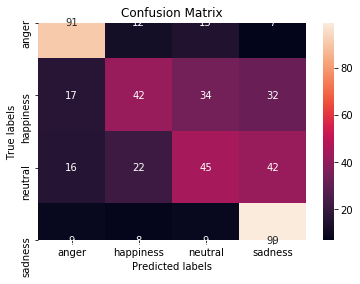

 61%|██████    | 36/59 [9:45:58<6:10:59, 967.80s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.73      0.71       125
   happiness       0.50      0.34      0.40       125
     neutral       0.44      0.36      0.39       125
     sadness       0.55      0.79      0.65       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.54      0.55      0.54       500
weighted avg       0.54      0.55      0.54       500
 

Train Epoch: 37 [0/3760 (0%)]	Loss: 1.025917

Train Epoch: 37 [640/3760 (17%)]	Loss: 0.956621

Train Epoch: 37 [1280/3760 (34%)]	Loss: 1.020549

Train Epoch: 37 [1920/3760 (51%)]	Loss: 1.051994

Train Epoch: 37 [2560/3760 (68%)]	Loss: 1.095706

Train Epoch: 37 [3200/3760 (85%)]	Loss: 1.034046


Train set: Average loss: 0.0160


Train Accuracy: 2133/3760 (57%)


Test set: Average loss: 0.0164, Accuracy: 276/500 (55%)



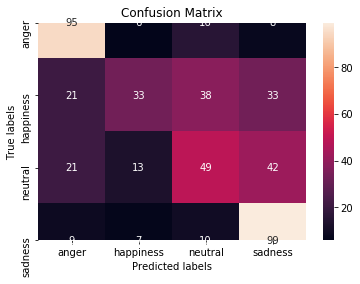

 63%|██████▎   | 37/59 [10:02:04<5:54:39, 967.24s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.76      0.70       125
   happiness       0.56      0.26      0.36       125
     neutral       0.43      0.39      0.41       125
     sadness       0.54      0.79      0.64       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.53       500
weighted avg       0.55      0.55      0.53       500
 

Train Epoch: 38 [0/3760 (0%)]	Loss: 1.214918

Train Epoch: 38 [640/3760 (17%)]	Loss: 0.955672

Train Epoch: 38 [1280/3760 (34%)]	Loss: 0.933319

Train Epoch: 38 [1920/3760 (51%)]	Loss: 1.170752

Train Epoch: 38 [2560/3760 (68%)]	Loss: 0.999678

Train Epoch: 38 [3200/3760 (85%)]	Loss: 0.968826


Train set: Average loss: 0.0159


Train Accuracy: 2119/3760 (56%)


Test set: Average loss: 0.0164, Accuracy: 274/500 (55%)



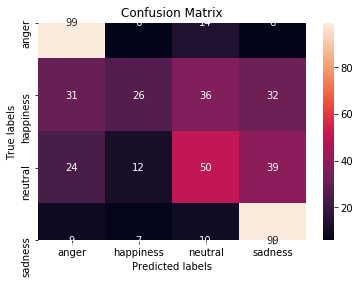

 64%|██████▍   | 38/59 [10:11:30<4:56:22, 846.79s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.61      0.79      0.69       125
   happiness       0.51      0.21      0.30       125
     neutral       0.45      0.40      0.43       125
     sadness       0.56      0.79      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.53      0.55      0.52       500
weighted avg       0.53      0.55      0.52       500
 

Train Epoch: 39 [0/3760 (0%)]	Loss: 0.879976

Train Epoch: 39 [640/3760 (17%)]	Loss: 1.002660

Train Epoch: 39 [1280/3760 (34%)]	Loss: 0.981360

Train Epoch: 39 [1920/3760 (51%)]	Loss: 0.913313

Train Epoch: 39 [2560/3760 (68%)]	Loss: 1.001091

Train Epoch: 39 [3200/3760 (85%)]	Loss: 1.015638


Train set: Average loss: 0.0159


Train Accuracy: 2151/3760 (57%)


Test set: Average loss: 0.0164, Accuracy: 282/500 (56%)



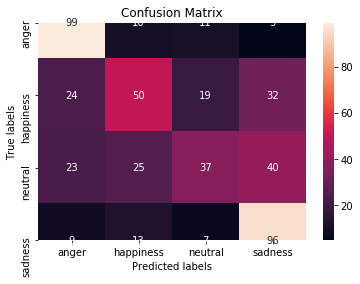

 66%|██████▌   | 39/59 [10:19:49<4:07:28, 742.43s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.64      0.79      0.71       125
   happiness       0.51      0.40      0.45       125
     neutral       0.50      0.30      0.37       125
     sadness       0.55      0.77      0.64       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 40 [0/3760 (0%)]	Loss: 1.145813

Train Epoch: 40 [640/3760 (17%)]	Loss: 1.052265

Train Epoch: 40 [1280/3760 (34%)]	Loss: 1.022782

Train Epoch: 40 [1920/3760 (51%)]	Loss: 1.026169

Train Epoch: 40 [2560/3760 (68%)]	Loss: 0.916218

Train Epoch: 40 [3200/3760 (85%)]	Loss: 0.926534


Train set: Average loss: 0.0157


Train Accuracy: 2148/3760 (57%)


Test set: Average loss: 0.0165, Accuracy: 271/500 (54%)



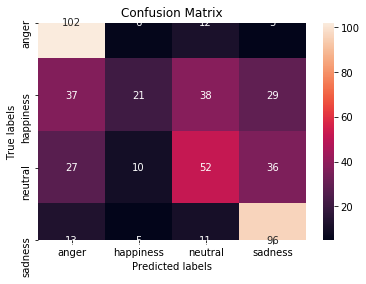

 68%|██████▊   | 40/59 [10:28:08<3:32:00, 669.50s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.57      0.82      0.67       125
   happiness       0.50      0.17      0.25       125
     neutral       0.46      0.42      0.44       125
     sadness       0.58      0.77      0.66       125

   micro avg       0.54      0.54      0.54       500
   macro avg       0.53      0.54      0.50       500
weighted avg       0.53      0.54      0.50       500
 

Train Epoch: 41 [0/3760 (0%)]	Loss: 1.078615

Train Epoch: 41 [640/3760 (17%)]	Loss: 1.084324

Train Epoch: 41 [1280/3760 (34%)]	Loss: 0.965248

Train Epoch: 41 [1920/3760 (51%)]	Loss: 1.048872

Train Epoch: 41 [2560/3760 (68%)]	Loss: 1.012070

Train Epoch: 41 [3200/3760 (85%)]	Loss: 0.831304


Train set: Average loss: 0.0157


Train Accuracy: 2129/3760 (57%)


Test set: Average loss: 0.0163, Accuracy: 281/500 (56%)



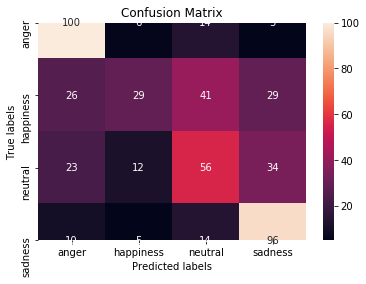

 69%|██████▉   | 41/59 [10:36:27<3:05:29, 618.32s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.63      0.80      0.70       125
   happiness       0.56      0.23      0.33       125
     neutral       0.45      0.45      0.45       125
     sadness       0.59      0.77      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 42 [0/3760 (0%)]	Loss: 0.958817

Train Epoch: 42 [640/3760 (17%)]	Loss: 0.991746

Train Epoch: 42 [1280/3760 (34%)]	Loss: 0.871980

Train Epoch: 42 [1920/3760 (51%)]	Loss: 0.944428

Train Epoch: 42 [2560/3760 (68%)]	Loss: 1.082714

Train Epoch: 42 [3200/3760 (85%)]	Loss: 0.956726


Train set: Average loss: 0.0157


Train Accuracy: 2186/3760 (58%)


Test set: Average loss: 0.0163, Accuracy: 273/500 (55%)



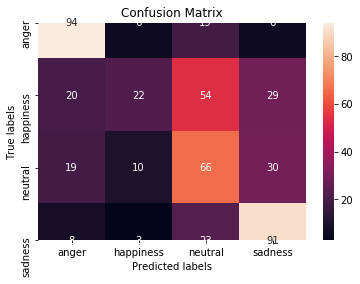

 71%|███████   | 42/59 [10:44:46<2:45:02, 582.47s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.67      0.75      0.71       125
   happiness       0.54      0.18      0.27       125
     neutral       0.41      0.53      0.46       125
     sadness       0.58      0.73      0.65       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.52       500
weighted avg       0.55      0.55      0.52       500
 

Train Epoch: 43 [0/3760 (0%)]	Loss: 1.024453

Train Epoch: 43 [640/3760 (17%)]	Loss: 1.063740

Train Epoch: 43 [1280/3760 (34%)]	Loss: 1.064073

Train Epoch: 43 [1920/3760 (51%)]	Loss: 1.001716

Train Epoch: 43 [2560/3760 (68%)]	Loss: 1.009284

Train Epoch: 43 [3200/3760 (85%)]	Loss: 0.864656


Train set: Average loss: 0.0156


Train Accuracy: 2180/3760 (58%)


Test set: Average loss: 0.0163, Accuracy: 278/500 (56%)



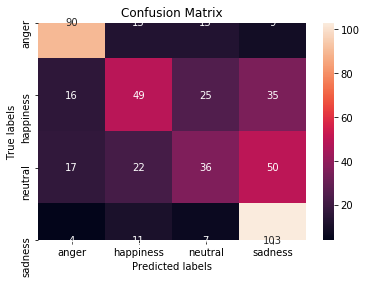

 73%|███████▎  | 43/59 [10:53:05<2:28:39, 557.50s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.71      0.72      0.71       125
   happiness       0.52      0.39      0.45       125
     neutral       0.44      0.29      0.35       125
     sadness       0.52      0.82      0.64       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 44 [0/3760 (0%)]	Loss: 1.112200

Train Epoch: 44 [640/3760 (17%)]	Loss: 0.979732

Train Epoch: 44 [1280/3760 (34%)]	Loss: 0.981119

Train Epoch: 44 [1920/3760 (51%)]	Loss: 0.901835

Train Epoch: 44 [2560/3760 (68%)]	Loss: 0.857994

Train Epoch: 44 [3200/3760 (85%)]	Loss: 0.970259


Train set: Average loss: 0.0157


Train Accuracy: 2188/3760 (58%)


Test set: Average loss: 0.0162, Accuracy: 282/500 (56%)



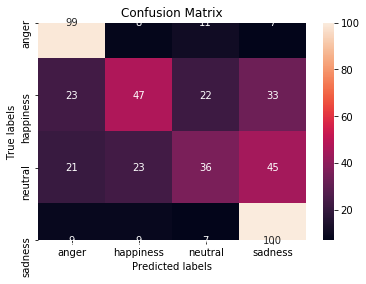

 75%|███████▍  | 44/59 [11:01:24<2:14:59, 539.98s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.65      0.79      0.71       125
   happiness       0.54      0.38      0.44       125
     neutral       0.47      0.29      0.36       125
     sadness       0.54      0.80      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 45 [0/3760 (0%)]	Loss: 0.843450

Train Epoch: 45 [640/3760 (17%)]	Loss: 0.992515

Train Epoch: 45 [1280/3760 (34%)]	Loss: 1.015398

Train Epoch: 45 [1920/3760 (51%)]	Loss: 0.994698

Train Epoch: 45 [2560/3760 (68%)]	Loss: 0.971961

Train Epoch: 45 [3200/3760 (85%)]	Loss: 1.114752


Train set: Average loss: 0.0156


Train Accuracy: 2213/3760 (59%)


Test set: Average loss: 0.0162, Accuracy: 282/500 (56%)



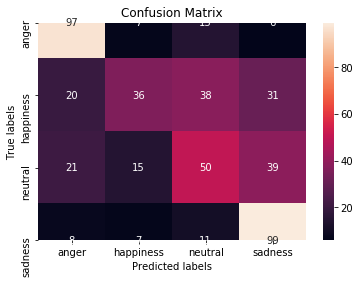

 76%|███████▋  | 45/59 [11:09:44<2:03:11, 527.97s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.78      0.72       125
   happiness       0.55      0.29      0.38       125
     neutral       0.44      0.40      0.42       125
     sadness       0.57      0.79      0.66       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.56      0.56      0.54       500
weighted avg       0.56      0.56      0.54       500
 

Train Epoch: 46 [0/3760 (0%)]	Loss: 0.855924

Train Epoch: 46 [640/3760 (17%)]	Loss: 1.017893

Train Epoch: 46 [1280/3760 (34%)]	Loss: 0.994248

Train Epoch: 46 [1920/3760 (51%)]	Loss: 0.881514

Train Epoch: 46 [2560/3760 (68%)]	Loss: 1.013406

Train Epoch: 46 [3200/3760 (85%)]	Loss: 1.017619


Train set: Average loss: 0.0156


Train Accuracy: 2196/3760 (58%)


Test set: Average loss: 0.0162, Accuracy: 286/500 (57%)



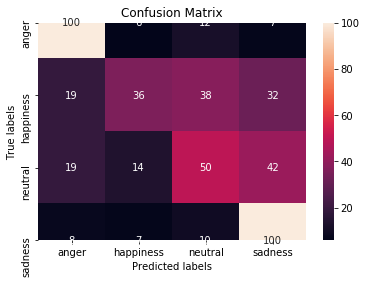

 78%|███████▊  | 46/59 [11:18:03<1:52:30, 519.24s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.80      0.74       125
   happiness       0.57      0.29      0.38       125
     neutral       0.45      0.40      0.43       125
     sadness       0.55      0.80      0.65       125

   micro avg       0.57      0.57      0.57       500
   macro avg       0.57      0.57      0.55       500
weighted avg       0.57      0.57      0.55       500
 

Train Epoch: 47 [0/3760 (0%)]	Loss: 0.989849

Train Epoch: 47 [640/3760 (17%)]	Loss: 1.046808

Train Epoch: 47 [1280/3760 (34%)]	Loss: 0.955206

Train Epoch: 47 [1920/3760 (51%)]	Loss: 1.020987

Train Epoch: 47 [2560/3760 (68%)]	Loss: 0.825288

Train Epoch: 47 [3200/3760 (85%)]	Loss: 0.984495


Train set: Average loss: 0.0154


Train Accuracy: 2211/3760 (59%)


Test set: Average loss: 0.0161, Accuracy: 286/500 (57%)



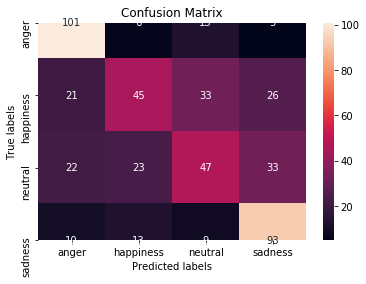

 80%|███████▉  | 47/59 [11:26:23<1:42:42, 513.50s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.81      0.72       125
   happiness       0.52      0.36      0.42       125
     neutral       0.46      0.38      0.41       125
     sadness       0.59      0.74      0.66       125

   micro avg       0.57      0.57      0.57       500
   macro avg       0.56      0.57      0.56       500
weighted avg       0.56      0.57      0.56       500
 

Train Epoch: 48 [0/3760 (0%)]	Loss: 1.024017

Train Epoch: 48 [640/3760 (17%)]	Loss: 0.964706

Train Epoch: 48 [1280/3760 (34%)]	Loss: 1.077787

Train Epoch: 48 [1920/3760 (51%)]	Loss: 0.965169

Train Epoch: 48 [2560/3760 (68%)]	Loss: 0.820620

Train Epoch: 48 [3200/3760 (85%)]	Loss: 0.984320


Train set: Average loss: 0.0156


Train Accuracy: 2194/3760 (58%)


Test set: Average loss: 0.0161, Accuracy: 288/500 (58%)



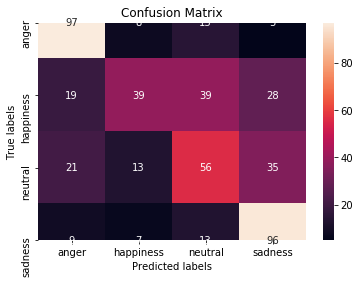

 81%|████████▏ | 48/59 [11:34:42<1:33:20, 509.11s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.78      0.72       125
   happiness       0.58      0.31      0.41       125
     neutral       0.46      0.45      0.45       125
     sadness       0.59      0.77      0.66       125

   micro avg       0.58      0.58      0.58       500
   macro avg       0.57      0.58      0.56       500
weighted avg       0.57      0.58      0.56       500
 

Train Epoch: 49 [0/3760 (0%)]	Loss: 0.961178

Train Epoch: 49 [640/3760 (17%)]	Loss: 1.024259

Train Epoch: 49 [1280/3760 (34%)]	Loss: 0.940485

Train Epoch: 49 [1920/3760 (51%)]	Loss: 0.841854

Train Epoch: 49 [2560/3760 (68%)]	Loss: 1.025175

Train Epoch: 49 [3200/3760 (85%)]	Loss: 1.023705


Train set: Average loss: 0.0153


Train Accuracy: 2225/3760 (59%)


Test set: Average loss: 0.0161, Accuracy: 279/500 (56%)



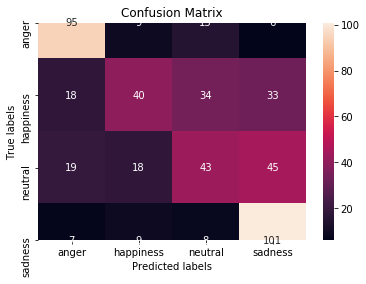

 83%|████████▎ | 49/59 [11:43:01<1:24:21, 506.14s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.76      0.72       125
   happiness       0.53      0.32      0.40       125
     neutral       0.43      0.34      0.38       125
     sadness       0.55      0.81      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 50 [0/3760 (0%)]	Loss: 0.987619

Train Epoch: 50 [640/3760 (17%)]	Loss: 0.908392

Train Epoch: 50 [1280/3760 (34%)]	Loss: 0.835507

Train Epoch: 50 [1920/3760 (51%)]	Loss: 1.122970

Train Epoch: 50 [2560/3760 (68%)]	Loss: 0.911712

Train Epoch: 50 [3200/3760 (85%)]	Loss: 1.031399


Train set: Average loss: 0.0153


Train Accuracy: 2246/3760 (60%)


Test set: Average loss: 0.0160, Accuracy: 289/500 (58%)



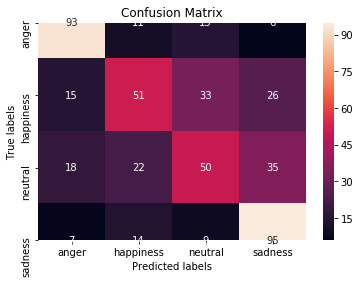

 85%|████████▍ | 50/59 [11:51:20<1:15:34, 503.87s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.70      0.74      0.72       125
   happiness       0.52      0.41      0.46       125
     neutral       0.47      0.40      0.43       125
     sadness       0.59      0.76      0.66       125

   micro avg       0.58      0.58      0.58       500
   macro avg       0.57      0.58      0.57       500
weighted avg       0.57      0.58      0.57       500
 

Train Epoch: 51 [0/3760 (0%)]	Loss: 0.994152

Train Epoch: 51 [640/3760 (17%)]	Loss: 1.097452

Train Epoch: 51 [1280/3760 (34%)]	Loss: 0.890144

Train Epoch: 51 [1920/3760 (51%)]	Loss: 1.088529

Train Epoch: 51 [2560/3760 (68%)]	Loss: 0.978609

Train Epoch: 51 [3200/3760 (85%)]	Loss: 0.938512


Train set: Average loss: 0.0153


Train Accuracy: 2240/3760 (60%)


Test set: Average loss: 0.0162, Accuracy: 278/500 (56%)



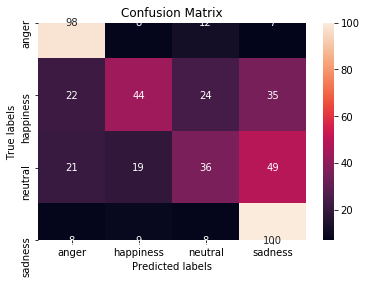

 86%|████████▋ | 51/59 [11:59:38<1:06:58, 502.32s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.66      0.78      0.72       125
   happiness       0.55      0.35      0.43       125
     neutral       0.45      0.29      0.35       125
     sadness       0.52      0.80      0.63       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.53       500
weighted avg       0.55      0.56      0.53       500
 

Train Epoch: 52 [0/3760 (0%)]	Loss: 0.937711

Train Epoch: 52 [640/3760 (17%)]	Loss: 0.983959

Train Epoch: 52 [1280/3760 (34%)]	Loss: 1.158307

Train Epoch: 52 [1920/3760 (51%)]	Loss: 1.047245

Train Epoch: 52 [2560/3760 (68%)]	Loss: 0.921262

Train Epoch: 52 [3200/3760 (85%)]	Loss: 0.909628


Train set: Average loss: 0.0152


Train Accuracy: 2224/3760 (59%)


Test set: Average loss: 0.0160, Accuracy: 281/500 (56%)



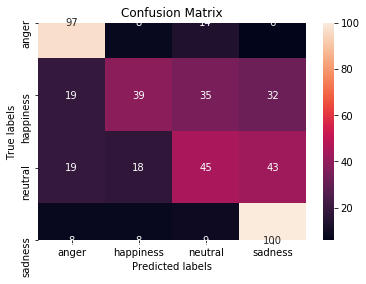

 88%|████████▊ | 52/59 [12:07:57<58:28, 501.22s/it]  


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.78      0.72       125
   happiness       0.53      0.31      0.39       125
     neutral       0.44      0.36      0.39       125
     sadness       0.55      0.80      0.65       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 53 [0/3760 (0%)]	Loss: 1.081147

Train Epoch: 53 [640/3760 (17%)]	Loss: 0.970076

Train Epoch: 53 [1280/3760 (34%)]	Loss: 0.981695

Train Epoch: 53 [1920/3760 (51%)]	Loss: 1.085470

Train Epoch: 53 [2560/3760 (68%)]	Loss: 0.958236

Train Epoch: 53 [3200/3760 (85%)]	Loss: 0.768229


Train set: Average loss: 0.0152


Train Accuracy: 2230/3760 (59%)


Test set: Average loss: 0.0160, Accuracy: 287/500 (57%)



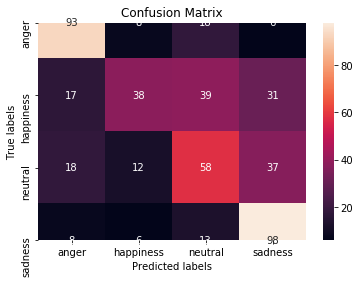

 90%|████████▉ | 53/59 [12:16:17<50:05, 500.86s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.74      0.71       125
   happiness       0.59      0.30      0.40       125
     neutral       0.45      0.46      0.46       125
     sadness       0.57      0.78      0.66       125

   micro avg       0.57      0.57      0.57       500
   macro avg       0.58      0.57      0.56       500
weighted avg       0.58      0.57      0.56       500
 

Train Epoch: 54 [0/3760 (0%)]	Loss: 0.997837

Train Epoch: 54 [640/3760 (17%)]	Loss: 0.878709

Train Epoch: 54 [1280/3760 (34%)]	Loss: 0.882827

Train Epoch: 54 [1920/3760 (51%)]	Loss: 1.053319

Train Epoch: 54 [2560/3760 (68%)]	Loss: 0.899419

Train Epoch: 54 [3200/3760 (85%)]	Loss: 0.902195


Train set: Average loss: 0.0152


Train Accuracy: 2224/3760 (59%)


Test set: Average loss: 0.0161, Accuracy: 288/500 (58%)



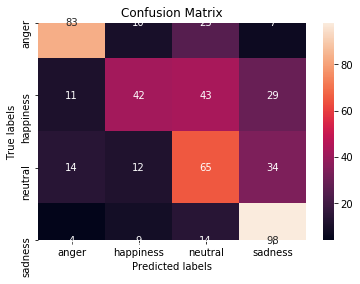

 92%|█████████▏| 54/59 [12:24:36<41:42, 500.41s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.74      0.66      0.70       125
   happiness       0.58      0.34      0.42       125
     neutral       0.44      0.52      0.48       125
     sadness       0.58      0.78      0.67       125

   micro avg       0.58      0.58      0.58       500
   macro avg       0.59      0.58      0.57       500
weighted avg       0.59      0.58      0.57       500
 

Train Epoch: 55 [0/3760 (0%)]	Loss: 0.929394

Train Epoch: 55 [640/3760 (17%)]	Loss: 0.909352

Train Epoch: 55 [1280/3760 (34%)]	Loss: 0.888209

Train Epoch: 55 [1920/3760 (51%)]	Loss: 0.926278

Train Epoch: 55 [2560/3760 (68%)]	Loss: 1.155514

Train Epoch: 55 [3200/3760 (85%)]	Loss: 0.999557


Train set: Average loss: 0.0151


Train Accuracy: 2231/3760 (59%)


Test set: Average loss: 0.0161, Accuracy: 277/500 (55%)



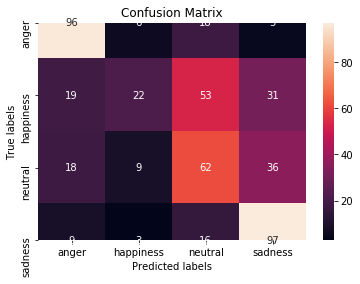

 93%|█████████▎| 55/59 [12:32:55<33:19, 499.96s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.77      0.72       125
   happiness       0.55      0.18      0.27       125
     neutral       0.42      0.50      0.45       125
     sadness       0.57      0.78      0.66       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.52       500
weighted avg       0.55      0.55      0.52       500
 

Train Epoch: 56 [0/3760 (0%)]	Loss: 0.978391

Train Epoch: 56 [640/3760 (17%)]	Loss: 0.903822

Train Epoch: 56 [1280/3760 (34%)]	Loss: 1.018773

Train Epoch: 56 [1920/3760 (51%)]	Loss: 0.903391

Train Epoch: 56 [2560/3760 (68%)]	Loss: 0.837210

Train Epoch: 56 [3200/3760 (85%)]	Loss: 0.922292


Train set: Average loss: 0.0150


Train Accuracy: 2254/3760 (60%)


Test set: Average loss: 0.0161, Accuracy: 274/500 (55%)



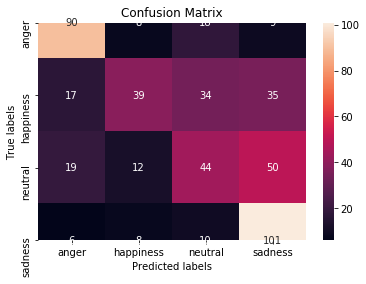

 95%|█████████▍| 56/59 [12:41:15<24:59, 499.76s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.72      0.70       125
   happiness       0.58      0.31      0.41       125
     neutral       0.42      0.35      0.38       125
     sadness       0.52      0.81      0.63       125

   micro avg       0.55      0.55      0.55       500
   macro avg       0.55      0.55      0.53       500
weighted avg       0.55      0.55      0.53       500
 

Train Epoch: 57 [0/3760 (0%)]	Loss: 1.067837

Train Epoch: 57 [640/3760 (17%)]	Loss: 0.891826

Train Epoch: 57 [1280/3760 (34%)]	Loss: 0.848099

Train Epoch: 57 [1920/3760 (51%)]	Loss: 1.022646

Train Epoch: 57 [2560/3760 (68%)]	Loss: 0.899728

Train Epoch: 57 [3200/3760 (85%)]	Loss: 0.907337


Train set: Average loss: 0.0152


Train Accuracy: 2234/3760 (59%)


Test set: Average loss: 0.0160, Accuracy: 281/500 (56%)



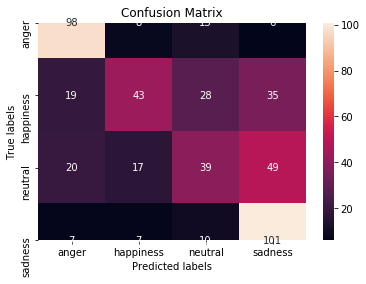

 97%|█████████▋| 57/59 [12:49:51<16:49, 504.64s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.78      0.73       125
   happiness       0.57      0.34      0.43       125
     neutral       0.43      0.31      0.36       125
     sadness       0.53      0.81      0.64       125

   micro avg       0.56      0.56      0.56       500
   macro avg       0.55      0.56      0.54       500
weighted avg       0.55      0.56      0.54       500
 

Train Epoch: 58 [0/3760 (0%)]	Loss: 1.016041

Train Epoch: 58 [640/3760 (17%)]	Loss: 0.983653

Train Epoch: 58 [1280/3760 (34%)]	Loss: 1.187141

Train Epoch: 58 [1920/3760 (51%)]	Loss: 0.933575

Train Epoch: 58 [2560/3760 (68%)]	Loss: 0.941297

Train Epoch: 58 [3200/3760 (85%)]	Loss: 1.022969


Train set: Average loss: 0.0149


Train Accuracy: 2264/3760 (60%)


Test set: Average loss: 0.0160, Accuracy: 292/500 (58%)



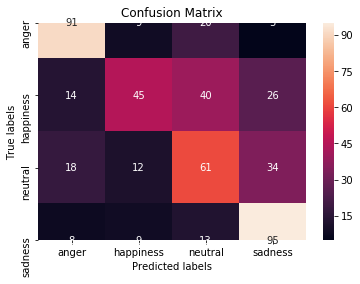

 98%|█████████▊| 58/59 [12:58:08<08:22, 502.56s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.69      0.73      0.71       125
   happiness       0.60      0.36      0.45       125
     neutral       0.46      0.49      0.47       125
     sadness       0.59      0.76      0.67       125

   micro avg       0.58      0.58      0.58       500
   macro avg       0.59      0.58      0.57       500
weighted avg       0.59      0.58      0.57       500
 

Train Epoch: 59 [0/3760 (0%)]	Loss: 1.031548

Train Epoch: 59 [640/3760 (17%)]	Loss: 0.947905

Train Epoch: 59 [1280/3760 (34%)]	Loss: 0.891603

Train Epoch: 59 [1920/3760 (51%)]	Loss: 0.870071

Train Epoch: 59 [2560/3760 (68%)]	Loss: 0.947159

Train Epoch: 59 [3200/3760 (85%)]	Loss: 1.012737


Train set: Average loss: 0.0150


Train Accuracy: 2261/3760 (60%)


Test set: Average loss: 0.0160, Accuracy: 287/500 (57%)



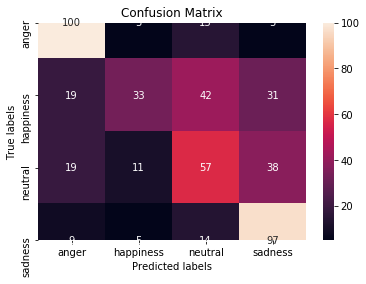

100%|██████████| 59/59 [13:06:27<00:00, 799.78s/it]


 Classification Report 
               precision    recall  f1-score   support

       anger       0.68      0.80      0.74       125
   happiness       0.61      0.26      0.37       125
     neutral       0.45      0.46      0.45       125
     sadness       0.57      0.78      0.66       125

   micro avg       0.57      0.57      0.57       500
   macro avg       0.58      0.57      0.55       500
weighted avg       0.58      0.57      0.55       500
 



In [25]:
from tqdm import tqdm
history = []
n_epoch = 60
for epoch in tqdm(range(1, n_epoch)):
#     exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch, model)
    
    test_loss, test_acc = test(model)
    
#     plateau_scheduler.step(test_loss)
    
    history.append([train_loss, train_acc, test_loss, test_acc])

In [26]:
history_df = pd.DataFrame(history, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [27]:
history_df["epoch"] = [x for x in range(1, n_epoch)]

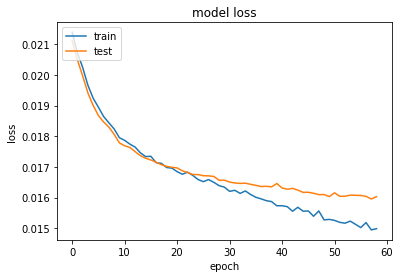

In [28]:
plt.plot(history_df.train_loss)
plt.plot(history_df.test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

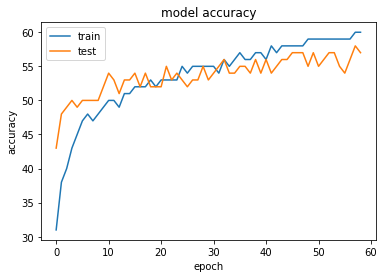

In [29]:
plt.plot(history_df.train_acc)
plt.plot(history_df.test_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()